In [353]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import waterfall_chart
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus
plt.rcParams['figure.figsize'] = [18, 10]

## Loading data


In [354]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Chosen columns:
     pphhsize - Household Size
     relate_duration_at_w6_years - july 2017-year and month when rel started
     w6_friend_connect_4 - partner knows my friends and I know my partner's friends before metting
     w6_otherdate - In the past year, have you ever met someone for dating, for romance, or for sex
     S1 - Are you married? (output)

### Dropping rows, which had nulls and changing categorical data

In [355]:
data = data[['pphhsize', 'relate_duration_at_w6_years', 'w6_friend_connect_4', 'w6_otherdate', 'S1']].dropna()
data['pphhsize'] = data['pphhsize'].astype(float)
data = pd.get_dummies(data)

#### Rows with an answer *Refused* in *w6_otherdate* also admitted as null

In [356]:
data = data.loc[data['w6_otherdate_Refused'] == 0] 
data.drop('w6_otherdate_Refused', axis=1, inplace=True)

#### Renaming columns and splitting for train and test

In [405]:
data.rename(columns={'relate_duration_at_w6_years': 'relate_duration',
            'w6_friend_connect_4_Yes': 'friends_connect',
            'w6_otherdate_Yes, I have met at least one person for dating, romance, or sex besides [Partner Name] in  the past year.': 'otherdate',
            'S1_Yes, I am Married':'married'},
            inplace=True)
#fixed otherdate column, which was opposite value in previous notebooks
data = data.reset_index()
data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate', 'married']]

X_data, y_data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate']], data[['married']]
y_data = np.array(y_data).ravel()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

### Training model

In [363]:
cls = RandomForestClassifier(n_estimators=500)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

### Accuracy

In [364]:
accuracy_score(y_pred, y_test)

0.8064046579330422

### Chosen observation

In [392]:
random_state = 5247
sample = X_test.sample(1, random_state=random_state)
sample

,pphhsize,relate_duration,friends_connect,otherdate
1835,4.0,12.083333,1,0


### Generating data

In [393]:
def generate_data(sample, X_data, z_shape):

    # generating data
    z_data = pd.concat([sample]*z_shape).reset_index(drop=True)
    z_data_copy = z_data.copy()
    rel_std = X_data['relate_duration'].std()
    ph_std = X_data['pphhsize'].std()
    z_data['relate_duration'] = np.random.normal(sample['relate_duration'], scale=rel_std/5, size=(z_shape,))
    z_data['pphhsize'] = np.round(np.random.normal(sample['pphhsize'], scale=ph_std/5, size=(z_shape,)))
    z_data

    # getting weights
    weights = (z_data[['relate_duration', 'pphhsize']].values - z_data_copy[['relate_duration', 'pphhsize']].values)**2
    weights = np.sqrt(weights.sum(axis=1))

    return z_data, weights

In [394]:
z_shape = 1000
z_data, weights = generate_data(sample, X_data, z_shape)

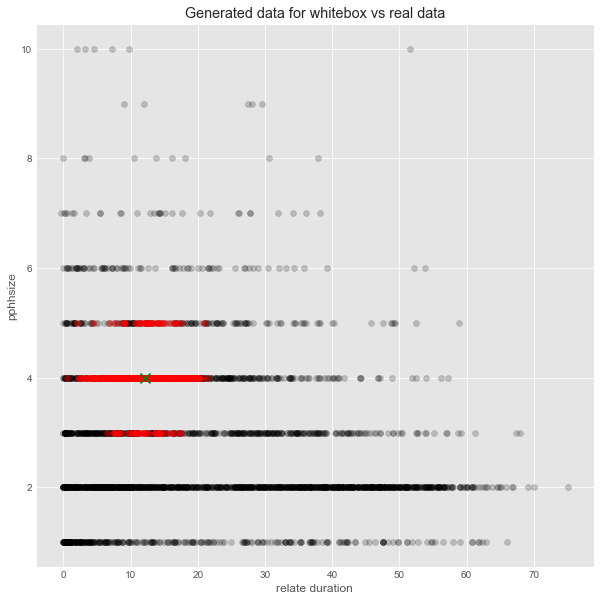

In [406]:
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
plt.title('Generated data for whitebox vs real data')
plt.scatter(X_data['relate_duration'], X_data['pphhsize'],  color='k', alpha=0.2)
plt.scatter(z_data['relate_duration'], z_data['pphhsize'], color='r', alpha=0.5)
plt.scatter(sample['relate_duration'], sample['pphhsize'], marker='x', s=100, color='g')
plt.xlabel('relate duration')
plt.ylabel('pphhsize')
plt.show()

#### Predicting gerenerated data by blackbox model

In [396]:
y_gen = cls.predict(z_data)

#### Preparing whitebox

In [397]:
wh_model = DecisionTreeRegressor(max_depth=2)
wh_model.fit(z_data, y_gen, sample_weight=weights)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

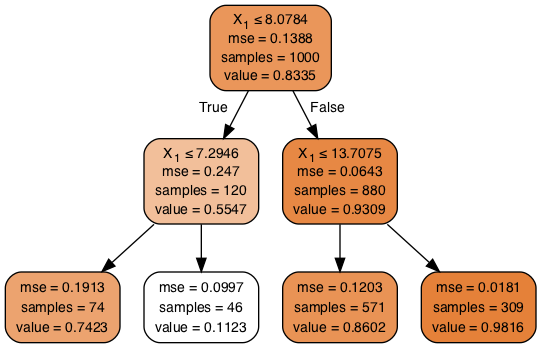

In [398]:
dot_data = StringIO()
export_graphviz(wh_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
dot_data.getvalue()
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

##### Lokalne przybliżenie modelem wskazuje, że dla najrótszych długości trwania związku (do 13 lat) prawdopodobieństwo bycia mężatką/żonatym jest niższe. Niżej porównano ten sam przykład z średniej odpowiedzi modelu.

### Mean model response

In [399]:
def mean_model_resp(data, model, sample):
    plt.style.use('seaborn-white')
    data = data.copy()
    plot_data = pd.DataFrame({'col': ['intercept'] + list(sample.keys())})
    plot_data.set_index('col', inplace=True)
    plot_data['proba'] = 0
    plot_data.loc['intercept', 'proba'] = model.predict_proba(data)[:,1].mean()
    for key, value in sample.items():
        data.loc[:, key] = value
        plot_data.loc[key, 'proba'] = model.predict_proba(data)[:,1].mean()
    plot_data['proba'] = plot_data['proba'].diff().fillna(plot_data['proba'])
    waterfall_chart.plot(plot_data.index, plot_data['proba'], rotation_value=0, formatting='{:,.3f}')  

#### First sample

In [400]:
sample = OrderedDict(X_test.sample(1, random_state=random_state).to_dict('records')[0])
sample

OrderedDict([('pphhsize', 4.0),
             ('relate_duration', 12.083333015441895),
             ('friends_connect', 1),
             ('otherdate', 0)])

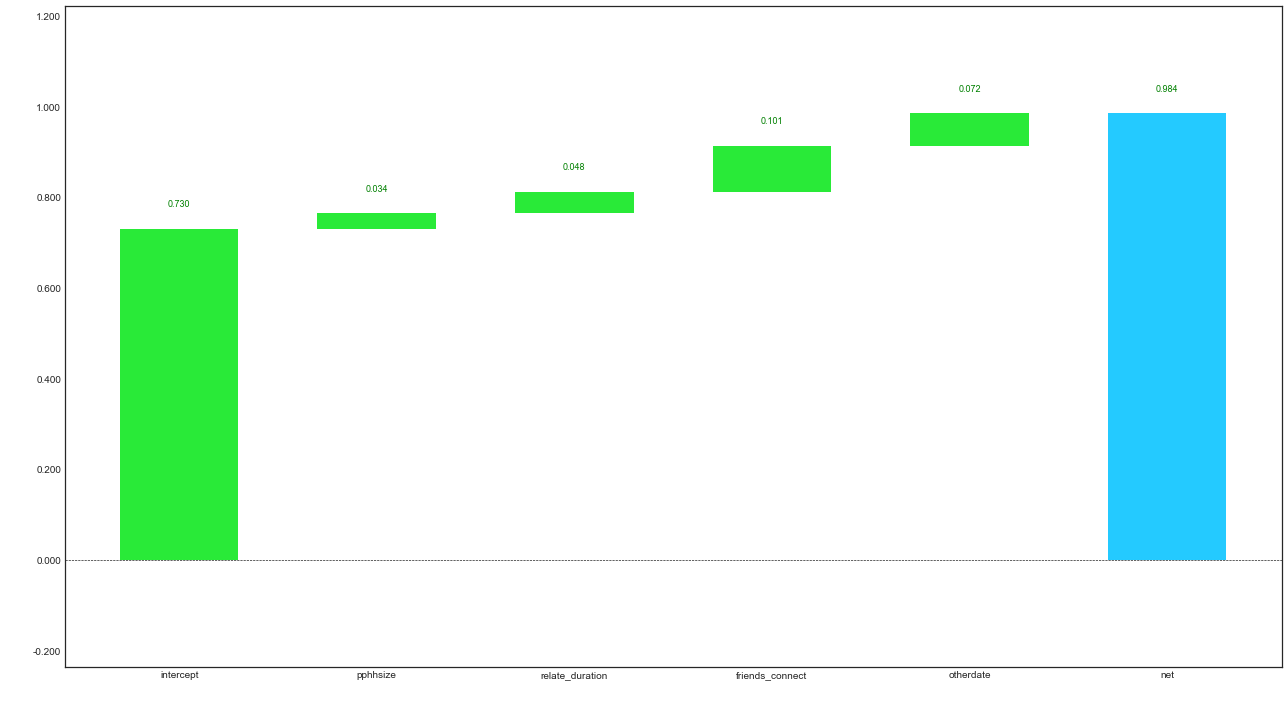

In [401]:
mean_model_resp(X_test, cls,  sample)

#### Changing order in sample

In [402]:
sample.move_to_end('pphhsize')
sample.move_to_end('relate_duration')
sample

OrderedDict([('friends_connect', 1),
             ('otherdate', 0),
             ('pphhsize', 4.0),
             ('relate_duration', 12.083333015441895)])

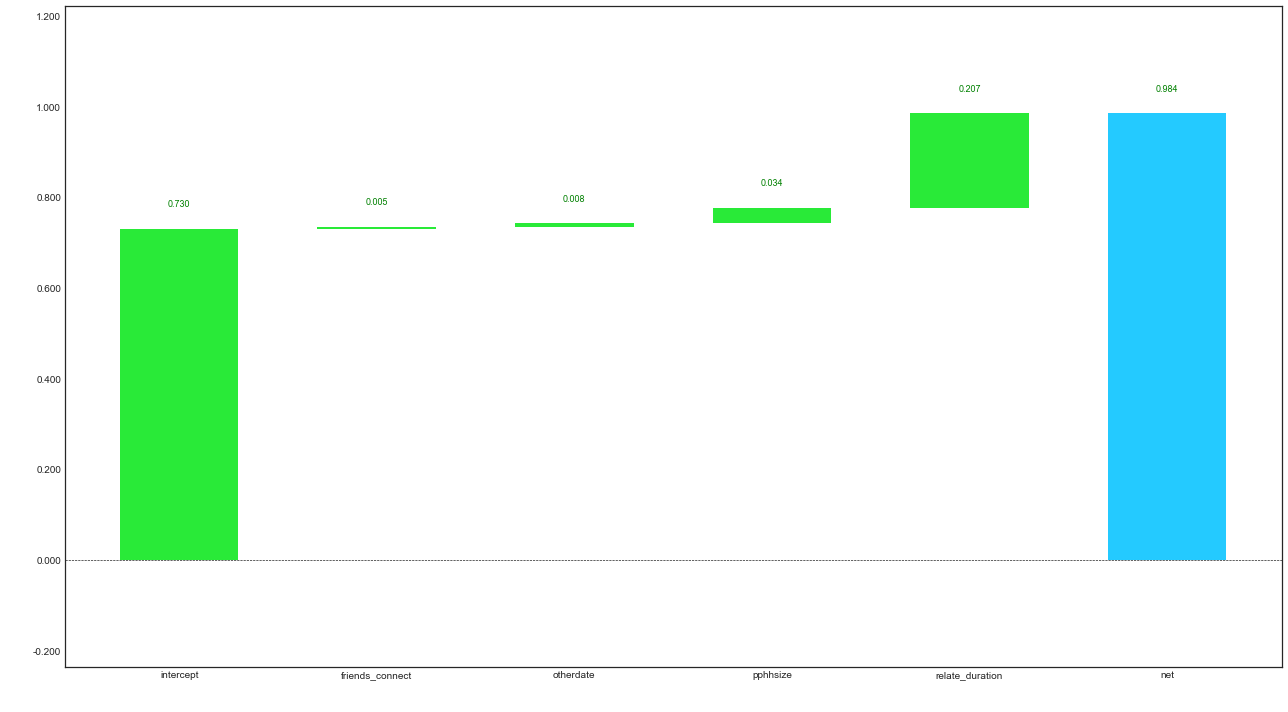

In [403]:
mean_model_resp(X_test, cls,  sample)

#### Zmienna wskazująca na długość związku w drugim przypadku daje kluczowy wkład w określeniu predykcji w modelu, natomiast przy pierwszej rotacji jest częsciowo przejmowana przez pozytywny czynnik wierności. W whiteboxie również zmienna dotycząca trwania związku powodowała rozróżnienie na małżeństwa i związki.